In [212]:
from pymongo import MongoClient
import pprint
import pandas as pd
# Requests sends and recieves HTTP requests.
import requests
import json
import time
from scipy import stats
import numpy as np
#import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels as sm
plt.style.use('ggplot')

import seaborn as sns

In [213]:
import matplotlib.pyplot as plt

In [214]:
client = MongoClient('localhost', 27017)
results = client['results']
runners = results['indiv']
new = client['new_db']
indiv = new['individual']

## Data Import and Cleaning

The `runners` collection includes all of the individual race results.  The below prints the collections in my results  

In [215]:
print('There are {} results in the list'.format(len(list(runners.find()))))

There are 31245 results in the list


I converted the collection to a dataframe and converted the finish time, originally in an HH:MM:SS string format to a new column in seconds.  The head, tail, and info show the expected results, with nice clean, consistent data for runners across all age groups.

In [216]:
### Create dataframe from indiv results collection, converts time to seconds. The head shows the expected results.
df = pd.DataFrame(list(runners.find()))
df.head()
df['Time(sec)'] = pd.to_timedelta(df['time']).astype('timedelta64[s]').astype(int)#.map('{:,.2f}'.format)
df.head()

,_id,name,time,age,ag,dist,Time(sec)
0,5f170b3bc94e506c54092382,Abdi Abdirahman,2:11:34,42,Men 40-44,Mar,7894
1,5f170b3bc94e506c54092383,Mustafa Mohamed,2:19:41,40,Men 40-44,Mar,8381
2,5f170b3bc94e506c54092384,Fredison Costa,2:21:29,42,Men 40-44,Mar,8489
3,5f170b3bc94e506c54092385,Vladimir Shatrov,2:26:17,41,Men 40-44,Mar,8777
4,5f170b3bc94e506c54092386,Miguel Ferrer,2:27:15,41,Men 40-44,Mar,8835


In [217]:
df.tail()

,_id,name,time,age,ag,dist,Time(sec)
31240,5f1aee4ac66862eb758a6129,Ricky Kuka,8:39:14,61,Men 60-64,Mar,31154
31241,5f1aee4ac66862eb758a612a,Adnan Shamsi,9:21:27,64,Men 60-64,Mar,33687
31242,5f1aee4ac66862eb758a612b,Hugo Mujica,9:25:21,62,Men 60-64,Mar,33921
31243,5f1aee4ac66862eb758a612c,Alan Kaufman,9:27:27,61,Men 60-64,Mar,34047
31244,5f1aee4ac66862eb758a612d,Randy Savitt,9:45:12,62,Men 60-64,Mar,35112


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31245 entries, 0 to 31244
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   _id        31245 non-null  object
 1   name       31245 non-null  object
 2   time       31245 non-null  object
 3   age        31245 non-null  int64 
 4   ag         31245 non-null  object
 5   dist       31245 non-null  object
 6   Time(sec)  31245 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.7+ MB


Next, I created different dataframes for each of the age groups and distances.

In [220]:
##set up 5 diff DF
agroup = ['Men 40-44', 'Men 45-49', 'Women 25-29', 'Women 30-34']
dist = ['Mar','Mar','Mile','Mile']

M_Mile = df[(df.ag.isin(agroup[:2])) & (df['dist'] == 'Mile') & (df['Time(sec)'] < 720)]

W_Mile = df[(df.ag.isin(agroup[2:])) & (df['dist'] == 'Mile') & (df['Time(sec)'] < 720)]

M_Mar = df[(df.ag.isin(agroup[:2])) & (df['dist'] == 'Mar') & (df['Time(sec)'] < 18884)]
W_Mar = df[(df.ag.isin(agroup[2:])) & (df['dist'] == 'Mar') & (df['Time(sec)'] < 18884)]


M_Mar_50 = df[(df['age']>49) & (df['age']<55) & (df['Time(sec)'] < 18884)]
M_Mar_55 = df[(df['age']>55) & (df['age']<60) & (df['Time(sec)'] < 18884)]
M_Mar_60 = df[(df['age']>60) & (df['Time(sec)'] < 18884)]
M_Mar_60.head()

,_id,name,time,age,ag,dist,Time(sec)
29845,5f1aee47c66862eb758a5bb6,Peter Laznicka,2:55:40,64,Men 60-64,Mar,10540
29847,5f1aee47c66862eb758a5bb8,Beau Atwater,2:59:21,61,Men 60-64,Mar,10761
29848,5f1aee47c66862eb758a5bb9,Joe Standerfer,2:59:26,63,Men 60-64,Mar,10766
29851,5f1aee47c66862eb758a5bbc,Jaime Palacios,3:05:04,64,Men 60-64,Mar,11104
29852,5f1aee47c66862eb758a5bbd,Dominique Chauvelier,3:06:44,63,Men 60-64,Mar,11204


I also made dataframes that included runners who competed in both races. There are some duplicate names within each gender so I made a new column, `nameage`, that combined the runners' names and ages, hopefully resulting in a unique identifier for each runner.

In [200]:
M_Mile['nameage'] =  M_Mile['age'].astype(str) + M_Mile["name"]
W_Mile['nameage'] = W_Mile['age'].astype(str) + W_Mile["name"]
M_Mar['nameage'] = M_Mar['age'].astype(str) + M_Mar["name"]
W_Mar['nameage'] = W_Mar['age'].astype(str) + W_Mar["name"]

M_repeats = pd.merge(left=M_Mar, right=M_Mile, left_on='nameage', right_on='nameage')
W_repeats = pd.merge(left=W_Mar, right=W_Mile, left_on='nameage', right_on='nameage')
M_repeats.mean()

/Users/annebarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/annebarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/annebarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

age_x             44.031250
Time(sec)_x    14607.200893
age_y             44.031250
Time(sec)_y      379.437500
dtype: float64

# Peanut Butter Graphing Time!

Creates the values along the x-axis, in HH:MM:SS format

In [247]:

secs_mile = [300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]

y = [2+.25*x for x in range(0, 16)]
secs_mar = [3600*x for x in y]
    
def formatTime(ls):
    l = []
    for i in ls:
        l.append(time.strftime('%H:%M:%S', time.gmtime(i)))
    return l


mar_x = formatTime(secs_mar)
print(len(secs_mar))
print(len(mar_x))

mile_x = formatTime(secs_mile)
#print(mile_x)
#mar_x_range = [[7800, 25000], [240,800], [7800,25000], [240,800], [7800,25000]]
#print(mar_x_range)
bins = [secs_mar, secs_mile, secs_mar, secs_mile, secs_mar, secs_mar, secs_mar]
x_axis_labels = [mar_x, mile_x, mar_x, mile_x, mar_x, mar_x, mar_x]

16
16


In [248]:


data =[["Marathon Times for Men 40-49 and Women 25-34",M_Mar['Time(sec)'], W_Mar['Time(sec)']], ['Mile Times for Men 40-49 and Women 25-34', M_Mile['Time(sec)'], W_Mile['Time(sec)']], ['Marathon Times for Men 40-49 and Women 25-34 (repeats)', M_repeats['Time(sec)_x'], W_repeats['Time(sec)_x']], ['Mile Times for Men 40-49 and Women 25-34 (repeats)', M_repeats['Time(sec)_y'], W_repeats['Time(sec)_y']], ['Mile Times for Men 50-54 and Women 25-34', M_Mar_50['Time(sec)'], W_Mar['Time(sec)']], ['Marathon Finish Times for Men 55-59 and Women 25-34', M_Mar_55['Time(sec)'], W_Mar['Time(sec)']], ['Marathon Finish Times for Men 60-64 and Women 25-34', M_Mar_60['Time(sec)'], W_Mar['Time(sec)']]]

print(data[6])
       

['Marathon Finish Times for Men 60-64 and Women 25-34', 29845    10540
29847    10761
29848    10766
29851    11104
29852    11204
         ...  
30809    18832
30810    18835
30811    18836
30812    18841
30813    18851
Name: Time(sec), Length: 629, dtype: int64, 9701      8558
9702      8751
9703      8868
9704      9115
9705     10072
         ...  
15806    18863
15807    18864
15808    18864
15809    18867
15810    18877
Name: Time(sec), Length: 5310, dtype: int64]


7
0
1
2
3
4
5
6
made it


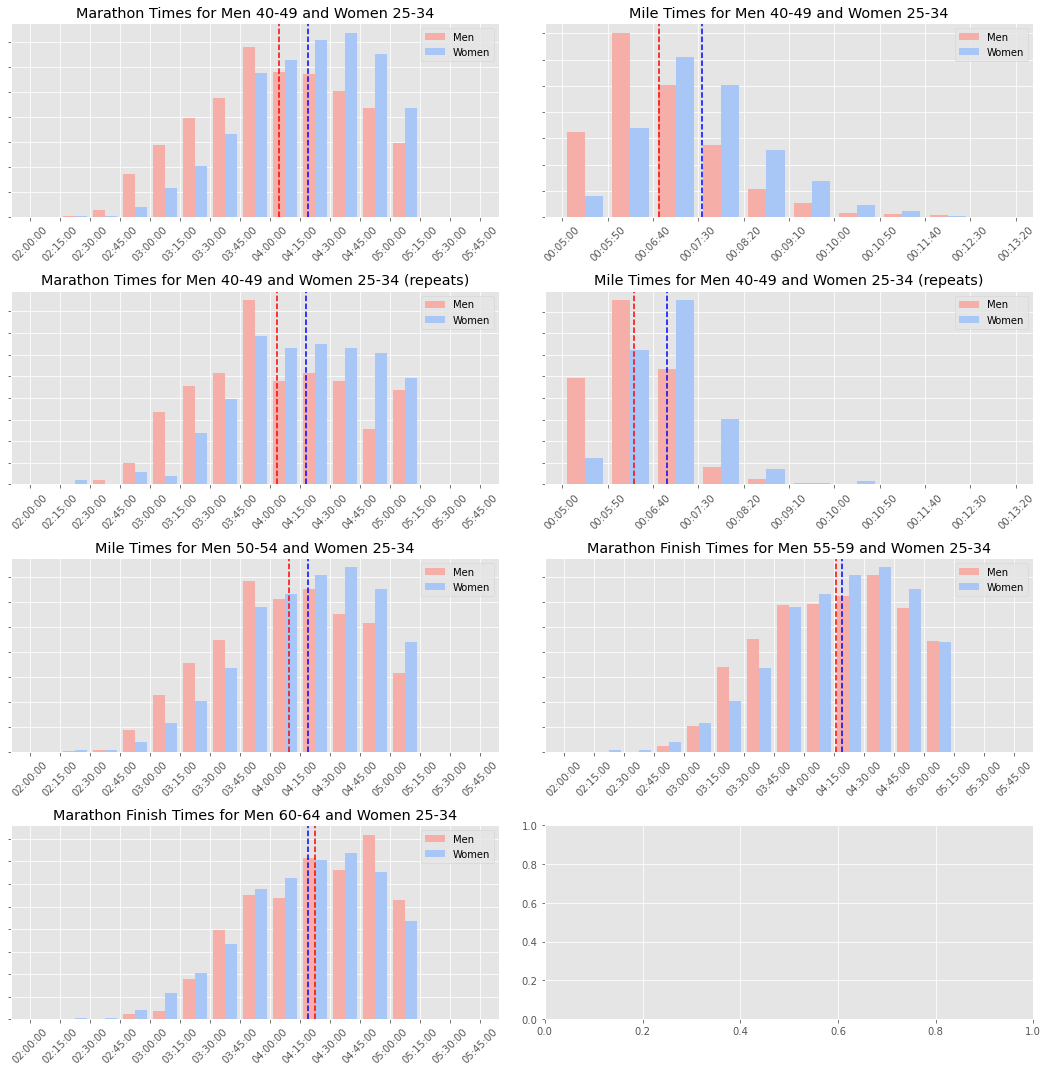

In [262]:
print(len(data))
def plot(data, labels, bins):
    fig, axes = plt.subplots(4,2, figsize = (15, 15))
    for i, ax in enumerate(axes.flat):
        ax.hist(data[i][1:], bins = bins[i], density = True, align = ('mid'), color = ['#F6AEA8', '#A8C7F6'], label = ['Men', 'Women'])
        ax.spines["bottom"].set_visible(True)      
        ax.spines["left"].set_visible(True)
        ax.axvline(data[i][1].mean(), color = 'red', linestyle="--")
        ax.axvline(data[i][2].mean(), color = 'blue', linestyle="--")
        ax.set_title(data[i][0])
        ax.set_yticklabels([])
        ax.set_xticklabels(labels[i], rotation = '45')
        ax.set_xticks(bins[i])
        ax.legend()
        print(i)
        if i == (len(data)-1):
            print('made it')
            break
    fig.tight_layout()

plot(data, x_axis_labels, bins)

In [252]:
def calculate_t_test(data, type_I_error_rate):
    ttest = stats.ttest_ind(data[1], data[2], equal_var = False)
    print('Race: {}, p-value: {}'.format(data[0], ttest[1]))

error = .05

for i in data:
    calculate_t_test(i, error)
          
print(M_Mar_60.info())
print(W_Mar.mean())
print(M_Mar_55.info())


Race: Marathon Times for Men 40-49 and Women 25-34, p-value: 6.989849401833806e-125
Race: Mile Times for Men 40-49 and Women 25-34, p-value: 7.006868521433366e-54
Race: Marathon Times for Men 40-49 and Women 25-34 (repeats), p-value: 1.666429008612427e-05
Race: Mile Times for Men 40-49 and Women 25-34 (repeats), p-value: 9.418413407414008e-15
Race: Mile Times for Men 50-54 and Women 25-34, p-value: 4.761608526661595e-36
Race: Marathon Finish Times for Men 55-59 and Women 25-34, p-value: 0.005221167232747715
Race: Marathon Finish Times for Men 60-64 and Women 25-34, p-value: 0.004433752415344179
<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 29845 to 30813
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   _id        629 non-null    object
 1   name       629 non-null    object
 2   time       629 non-null    object
 3   age        629 non-null    int64 
 4   ag         629 non-null    object
 5   dist      

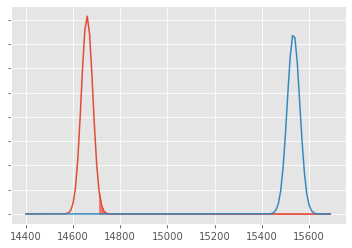

In [284]:
x = np.arange(14400, 15700, 10)
men = stats.norm(sub_12_list[0].mean(), sub_12_list[0].std()/np.sqrt(sub_12_list[0].count()))
women = stats.norm(sub_12_list[1].mean(), sub_12_list[1].std()/np.sqrt(sub_12_list[1].count()))

fig,ax = plt.subplots()
ax.plot(x, men.pdf(x))
ax.plot(x, women.pdf(x))
ax.set_yticklabels([])
statistic = men.ppf(.975)
ax.fill_between(x, men.pdf(x), where=(x >= statistic), color="red", alpha=0.5)

Text(0.5, 1.0, 'Normal Distribution of Mile Times for Men 40-49 and Women 25-34')

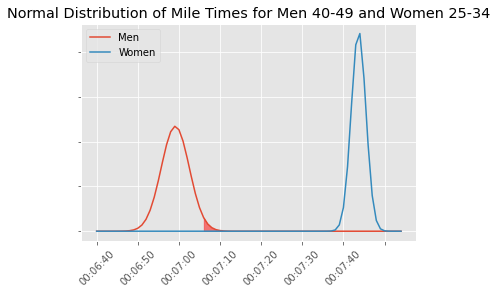

In [401]:
# Women vs Men 40-49 mile time
x = np.arange(390, 465, 1)
men = stats.norm(sub_12_list[2].mean(), sub_12_list[2].std()/np.sqrt(sub_12_list[2].count()))
women = stats.norm(sub_12_list[3].mean(), sub_12_list[3].std()/np.sqrt(sub_12_list[3].count()))

fig,ax = plt.subplots()
ax.plot(x, men.pdf(x), label = 'Men')
ax.plot(x, women.pdf(x), label = 'Women')
ax.set_yticklabels([])
ax.set_xticklabels(format_time([390+10*x for x in range(0, 8)]), rotation = "45")
statistic = men.ppf(.975)
ax.fill_between(x, men.pdf(x), where=(x >= statistic), color="red", alpha=0.5)
ax.legend()
ax.set_title("Normal Distribution of Mile Times for Men 40-49 and Women 25-34")

In [254]:
W_Mar_sorted = W_Mar.sort_values('Time(sec)')
M_Mar_sorted = M_Mar_50.sort_values('Time(sec)')

In [255]:
W_Mar_sorted.head()

,_id,name,time,age,ag,dist,Time(sec)
9701,5f17166fc94e506c54094969,Joyciline Jepkosgei,2:22:38,25,Women 25-29,Mar,8558
9702,5f17166fc94e506c5409496a,Ruti Aga,2:25:51,25,Women 25-29,Mar,8751
13306,5f171b11c94e506c5409577f,Kellyn Taylor,2:26:52,33,Women 30-34,Mar,8812
13307,5f171b11c94e506c54095780,Ellie Pashley,2:27:07,30,Women 30-34,Mar,8827
13308,5f171b11c94e506c54095781,Belaynesh Fikadu,2:27:27,32,Women 30-34,Mar,8847
